In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [9]:
stock_files = {
    "AAPL": "/kaggle/input/scrapped-stock-data/AAPL.csv",
    "AMZN": "/kaggle/input/scrapped-stock-data/AMZN.csv",
    "MSFT": "/kaggle/input/scrapped-stock-data/MSFT.csv",
    "NVDA": "/kaggle/input/scrapped-stock-data/NVDA.csv",
    "TSLA": "/kaggle/input/scrapped-stock-data/TSLA.csv"
}

dfs = []
for stock, path in stock_files.items():
    df = pd.read_csv(path)
    df['stock'] = stock
    dfs.append(df)

df_all = pd.concat(dfs)
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all = df_all.sort_values(['Date', 'stock']).reset_index(drop=True)

print("Data loaded:", df_all.shape)


Data loaded: (12995, 20)


In [10]:
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_20', 'SMA_50', 'SMA_200',
    'EMA_12', 'EMA_26',
    'MACD', 'MACD_Signal',
    'RSI',
    'BB_Middle', 'BB_Upper', 'BB_Lower',
    'ATR', 'OBV'
]

# Drop rows where moving averages or indicators are missing
print("Rows before dropping NaNs:", len(df_all))
df_all = df_all.dropna().reset_index(drop=True)
print("Rows after dropping NaNs:", len(df_all))

# Encode stock ID
df_all['stock_id'] = df_all['stock'].astype('category').cat.codes
features.append('stock_id')

# Scale features including target Close
scaler = MinMaxScaler()
df_all[features] = scaler.fit_transform(df_all[features])

print("Features normalized. Ready for dataset creation.")


Rows before dropping NaNs: 12995
Rows after dropping NaNs: 12000
Features normalized. Ready for dataset creation.


In [11]:
sequence_length = 60  # 60 days
target_col = 'Close'

class StockDataset(Dataset):
    def __init__(self, df, features, seq_len):
        self.X = []
        self.y = []
        groups = df.groupby('stock')
        for stock, data in groups:
            for i in range(len(data) - seq_len):
                seq_x = data[features].iloc[i:i+seq_len].values
                seq_y = data[target_col].iloc[i+seq_len]
                self.X.append(seq_x)
                self.y.append(seq_y)
        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Train / Val / Test split
cut1 = int(len(df_all) * 0.7)
cut2 = int(len(df_all) * 0.85)

df_train = df_all.iloc[:cut1]
df_val = df_all.iloc[cut1:cut2]
df_test = df_all.iloc[cut2:]

train_ds = StockDataset(df_train, features, sequence_length)
val_ds = StockDataset(df_val, features, sequence_length)
test_ds = StockDataset(df_test, features, sequence_length)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

print("Datasets and DataLoaders ready.")


Datasets and DataLoaders ready.


In [12]:
class LSTMInformerHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden, transformer_heads):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.lstm_fc = nn.Linear(lstm_hidden, 32)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=transformer_heads,
            dim_feedforward=64,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.trans_fc = nn.Linear(input_dim, 32)

        self.final_fc = nn.Linear(64, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # last timestep
        lstm_out = self.lstm_fc(lstm_out)

        trans_out = self.transformer(x)
        trans_out = trans_out.mean(dim=1)
        trans_out = self.trans_fc(trans_out)

        combined = torch.cat([lstm_out, trans_out], dim=1)
        out = self.final_fc(combined)
        return out.squeeze()

input_dim = len(features)
model = LSTMInformerHybrid(input_dim=input_dim, lstm_hidden=64, transformer_heads=1).to(device)
print("Model ready.")


Model ready.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()

best_val_loss = float('inf')
train_losses = []
val_losses = []

epochs = 50

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("  ↳ Saved best model.")


Epoch 1 | Train Loss: 0.000142 | Val Loss: 0.000145
  ↳ Saved best model.
Epoch 2 | Train Loss: 0.000080 | Val Loss: 0.000186
Epoch 3 | Train Loss: 0.000073 | Val Loss: 0.000135
  ↳ Saved best model.
Epoch 4 | Train Loss: 0.000075 | Val Loss: 0.000142
Epoch 5 | Train Loss: 0.000069 | Val Loss: 0.000144
Epoch 6 | Train Loss: 0.000068 | Val Loss: 0.000148
Epoch 7 | Train Loss: 0.000073 | Val Loss: 0.000126
  ↳ Saved best model.
Epoch 8 | Train Loss: 0.000075 | Val Loss: 0.000131
Epoch 9 | Train Loss: 0.000073 | Val Loss: 0.000157
Epoch 10 | Train Loss: 0.000084 | Val Loss: 0.000122
  ↳ Saved best model.
Epoch 11 | Train Loss: 0.000066 | Val Loss: 0.000150
Epoch 12 | Train Loss: 0.000066 | Val Loss: 0.000116
  ↳ Saved best model.
Epoch 13 | Train Loss: 0.000066 | Val Loss: 0.000118
Epoch 14 | Train Loss: 0.000059 | Val Loss: 0.000119
Epoch 15 | Train Loss: 0.000062 | Val Loss: 0.000122
Epoch 16 | Train Loss: 0.000063 | Val Loss: 0.000132
Epoch 17 | Train Loss: 0.000059 | Val Loss: 0.00011

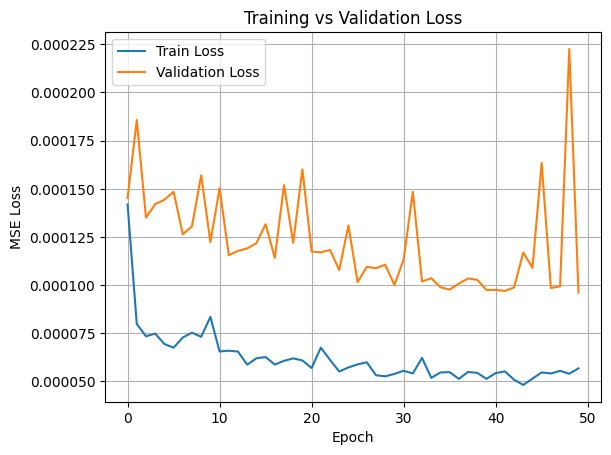

In [15]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_31/946517999.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


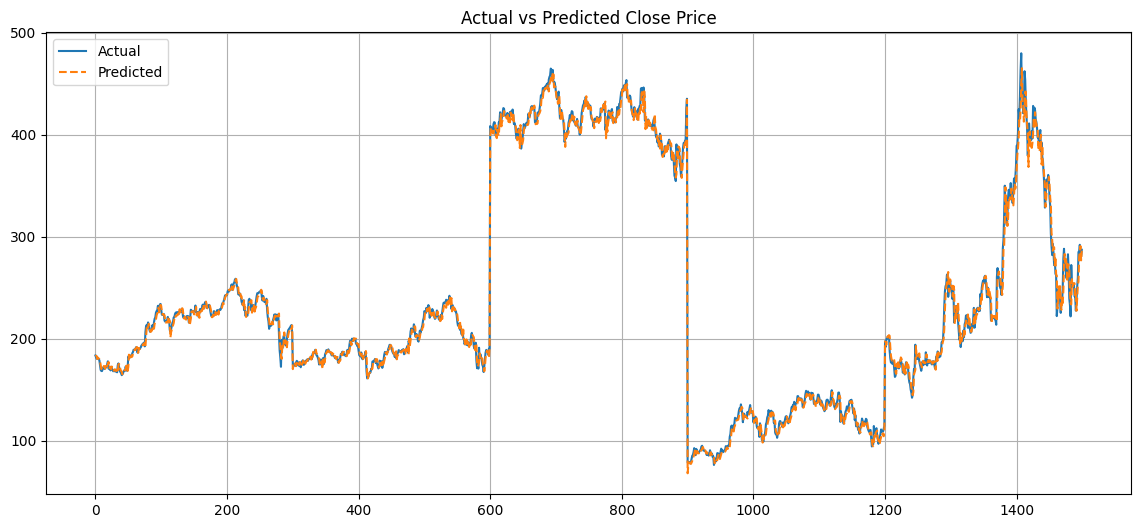

MAE: 4.66 | RMSE: 7.06 | R²: 0.9957


In [16]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

# Reverse scaling
close_min = scaler.data_min_[features.index("Close")]
close_max = scaler.data_max_[features.index("Close")]

y_true_rescaled = np.array(y_true)*(close_max - close_min) + close_min
y_pred_rescaled = np.array(y_pred)*(close_max - close_min) + close_min

plt.figure(figsize=(14, 6))
plt.plot(y_true_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted", linestyle='--')
plt.title("Actual vs Predicted Close Price")
plt.legend()
plt.grid()
plt.show()

mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled))
r2 = r2_score(y_true_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")
